In [2]:
### Import Modules ###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef

In [3]:
## Obtained Data From: 
# https://www.kaggle.com/zlatankr/titanic-random-forest-82-78/data

# Read in Data #
df_titanic = pd.read_csv("titanic.csv", dtype=
                        {'pclass': 'category', #Passenger Class - 1-3
                         'survived': float, # Categorical - Survived Y/N
                         'name': str, # Name of Passenger
                         'sex': 'category', # Sex of Passenger
                         'age': float, # Age of Passenger
                         'sibsp': float, # Num of Siblings on Board
                         'parch': float, # Num of Parents on Board
                         'ticket': str, # Ticket Num
                         'fare': float, # Passenger Fare
                         'cabin': str, # Passenger's Cabin
                         'embarked': 'category', # Location of Embarkment
                         'boat': 'category', # Lifeboat (if survived)
                         'body': float, # Body # if not survived
                        })
# List to Drop
to_drop = ['boat', # Determination of survived/not
           'body', # Determination of survived/not
           'home.dest', # N/A
          ]

# Drop Columns
df_titanic.drop(columns=to_drop, inplace=True) 

# Remove observation if missing survived 
df_titanic = df_titanic.dropna(subset=['survived'])

# Show df
print(df_titanic.shape)
df_titanic.head(5)

(1309, 11)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S


In [3]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   category
 1   survived  1309 non-null   float64 
 2   name      1309 non-null   object  
 3   sex       1309 non-null   category
 4   age       1046 non-null   float64 
 5   sibsp     1309 non-null   float64 
 6   parch     1309 non-null   float64 
 7   ticket    1309 non-null   object  
 8   fare      1308 non-null   float64 
 9   cabin     295 non-null    object  
 10  embarked  1307 non-null   category
dtypes: category(3), float64(5), object(3)
memory usage: 96.0+ KB


In [4]:
### Split into Train/Test ###
train, test = train_test_split(df_titanic, test_size=.2, random_state=5, shuffle=True)

# Print out shape of dfs 
print("Train Size:\n {}".format(train.shape))
print("Test Size:\n {}".format(test.shape))

data_types_dict = {'name': str}

train = train.astype(data_types_dict)
test = test.astype(data_types_dict)
#train['name'] = train['name'].astype(str)

Train Size:
 (1047, 11)
Test Size:
 (262, 11)


In [5]:
### FEATURE ENGINEERING ###

# View the Training Data for all Feature Engineering #
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 919 to 867
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1047 non-null   category
 1   survived  1047 non-null   float64 
 2   name      1047 non-null   object  
 3   sex       1047 non-null   category
 4   age       843 non-null    float64 
 5   sibsp     1047 non-null   float64 
 6   parch     1047 non-null   float64 
 7   ticket    1047 non-null   object  
 8   fare      1047 non-null   float64 
 9   cabin     246 non-null    object  
 10  embarked  1045 non-null   category
dtypes: category(3), float64(5), object(3)
memory usage: 76.9+ KB


In [6]:
## Feature Generation ##

## Names ##
def names(train, test):
    for i in [train, test]:
        i['name_len'] = i['name'].apply(lambda x: len(x))
        i['name_title'] = i['name'].apply(lambda x: x.split(',')[-1]).apply(lambda x: x.split()[0])
        del i['name']
    return train, test

## Age ##
def age_impute(train, test):
    for i in [train, test]:
        i['age_null_flag'] = i['age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['name_title', 'pclass'])['age']
        #i['age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

## Family Size - sibsp & parch ##
def fam_size(train, test):
    for i in [train, test]:
        i['fam_size'] = np.where((i['sibsp']+i['parch']) == 0 , 'solo',
                           np.where((i['sibsp']+i['parch']) <= 3,'nuclear', 'big'))
        del i['sibsp']
        del i['parch']
    return train, test

## Ticket ##
def ticket_grouped(train, test):
    for i in [train, test]:
        i['ticket_lett'] = i['ticket'].apply(lambda x: str(x)[0])
        i['ticket_lett'] = i['ticket_lett'].apply(lambda x: str(x))
        i['ticket_lett'] = np.where((i['ticket_lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['ticket_lett'],
                                   np.where((i['ticket_lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'low_ticket', 'other_ticket'))
        i['ticket'] = i['ticket'].astype(str)
        i['ticket_len'] = i['ticket'].apply(lambda x: len(x))
        del i['ticket']
    return train, test

## Cabin ##
def cabin(train, test):
    for i in [train, test]:
        i['cabin_letter'] = i['cabin'].apply(lambda x: str(x)[0])
        del i['cabin']
    return train, test

def cabin_num(train, test):
    for i in [train, test]:
        i['cabin_num1'] = i['cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['cabin_num1'].replace('an', np.NaN, inplace = True)
        i['cabin_num1'] = i['cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['cabin_num'] = pd.qcut(train['cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['cabin_num'], prefix = 'cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['cabin_num'], prefix = 'cabin_num')), axis = 1)
    del train['cabin_num']
    del test['cabin_num']
    del train['cabin_num1']
    del test['cabin_num1']
    return train, test

## Embarked ##
def embarked_impute(train, test):
    for i in [train, test]:
        i['embarked'] = i['embarked'].fillna('S')
    return train, test


## Categorical Data -> Dummy Data Type for SKL ##
def categorical_dummy(train, test, columns = ['pclass', 'sex', 'embarked', 'ticket_lett', 'cabin_letter', 'name_title', 'fam_size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [7]:
## Inpute Missing Values ##
# Impute the average of the train data set into the missing values of the test data set
test['fare'].fillna(train['fare'].mean(), inplace = True)

In [8]:
## Execute Feature Engineering ##
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)

train, test = ticket_grouped(train, test)
train, test = categorical_dummy(train, test, columns = ['pclass', 'sex', 'embarked', 'ticket_lett',
                                                                     'cabin_letter', 'name_title', 'fam_size'])
# Clean up age 
test['age'] = test['age'].astype(float)
test['age'] = test['age'].fillna(-1)
train['age'] = train['age'].astype(float)
train['age'] = train['age'].fillna(-1)

# Clean Up df Indexing #
train = train.reset_index()
train = train.drop(columns=['index'], axis=1)
test = test.reset_index()
test = test.drop(columns=['index'], axis=1)

print(len(train.columns))
train.head()

47


,survived,age,fare,name_len,age_null_flag,"cabin_num_(1.999, 30.0]","cabin_num_(30.0, 58.667]","cabin_num_(58.667, 148.0]",ticket_len,pclass_3,...,name_title_Miss.,name_title_Master.,name_title_Dr.,name_title_Rev.,name_title_Ms.,name_title_Major.,name_title_Mlle.,fam_size_solo,fam_size_nuclear,fam_size_big
0,0.0,18.5,7.2292,48,0,0,0,0,4,1,...,0,0,0,0,0,0,0,1,0,0
1,0.0,28.0,10.5000,29,0,0,0,0,16,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,29.0,9.4833,26,0,0,0,0,4,1,...,0,0,0,0,0,0,0,1,0,0
3,1.0,-1.0,51.8625,33,1,1,0,0,5,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,60.0,26.5500,15,0,0,0,0,6,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
%%time

# Create Classifier
rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

# Create Grid of Attributes to be used for optimization
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000, 1200, 1800]}

# Grid search the algorithm for optimum values
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarni

CPU times: user 8.05 s, sys: 1.08 s, total: 9.13 s
Wall time: 11min 25s


In [10]:
## Get Optimized Results from the Grid Search ##
print(gs.best_score_)
print(gs.best_params_)

0.8242597898758358
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1800}


In [11]:
## Model ## 
# use the attributes from the grid search
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1800,
                             min_samples_split=4,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8243


<AxesSubplot:>

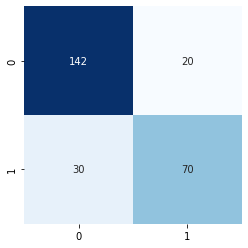

In [12]:
## Confusion Matrix ##
test_pred = test.drop(columns = "survived")
pred_test = rf.predict(test_pred)
cm = pd.DataFrame(confusion_matrix(test['survived'], pred_test))

# Visualize 

sns.heatmap(cm, annot=True, yticklabels=True, cbar=False, square=True, fmt="d", cmap=sns.color_palette("Blues", as_cmap=True))

In [13]:
## Metrics ##
print("Accuracy Score: {:.2f}%".format(100* accuracy_score(test['survived'], pred_test)))
print("Precision Score: {:.2f}%".format(100* precision_score(test['survived'], pred_test)))
print("Recall Score: {:.2f}%".format(100* recall_score(test['survived'], pred_test)))
print("F-Score: {:.2f}%".format(100* f1_score(test['survived'], pred_test)))
print("MCC Score: {:.2f}%".format(100* matthews_corrcoef(test['survived'], pred_test)))
print("ROC-AUC Score: {:.2f}%".format(100* roc_auc_score(test['survived'], pred_test)))

Accuracy Score: 80.92%
Precision Score: 77.78%
Recall Score: 70.00%
F-Score: 73.68%
MCC Score: 58.98%
ROC-AUC Score: 78.83%


In [14]:
## Feature Importance ##
# AKA - Gini Importance
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,name_len,0.119142
1,fare,0.115086
11,sex_male,0.098198
0,age,0.096997
12,sex_female,0.093030
33,name_title_Mr.,0.082671
7,ticket_len,0.039303
36,name_title_Miss.,0.028524
34,name_title_Mrs.,0.027292
8,pclass_3,0.025601
